# NX-421 Mini Project — Group P, Variant 1 (PCA) with Preprocessing 

## GLM Only



## 4. GLM

### 4a. Import Libraries

In [1]:
# Data handling and visualization imports
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
import pandas as pd
import matplotlib.pyplot as plt



# NiLearn imports
#%pip install nilearn
# %pip install nibabel
import nibabel as nib
from nilearn.glm.first_level import FirstLevelModel
from nilearn.plotting import plot_design_matrix
from nilearn import plotting
from nilearn.reporting import get_clusters_table
from nilearn.image import mean_img, get_data, coord_transform
from nilearn.glm import threshold_stats_img

In [3]:
# Base image (motion corrected + smoothed)
img_path = "/Users/pamelavandenenden/Desktop/NSSP fMRI Labs/fMRI_project/moco_smoothed-4mm.nii" ### TO BE REPLACED WITH YOUR PATH ###
img = nib.load(img_path)


In [4]:
TR = 0.72
n_scans = img.shape[-1]
scan_dur = n_scans * TR
print("n_scans:", n_scans, "scan_dur(s):", scan_dur)

n_scans: 568 scan_dur(s): 408.96


In [5]:
# Load event files 
ev_LR_path = "/Users/pamelavandenenden/Desktop/NSSP fMRI Labs/fMRI_project/subject101410/fMRI/tfMRI_MOTOR_LR/events_LR.csv"
ev_RL_path = "/Users/pamelavandenenden/Desktop/NSSP fMRI Labs/fMRI_project/subject101410/fMRI/tfMRI_MOTOR_RL/events_RL.csv"
ev_LR = pd.read_csv(ev_LR_path)
ev_RL = pd.read_csv(ev_RL_path)

In [6]:
# Clean event files

# ensure onset and duration are numeric
for df in (ev_LR, ev_RL):
    df["onset"] = pd.to_numeric(df["onset"], errors="coerce")
    df["duration"] = pd.to_numeric(df["duration"], errors="coerce")

# change condition column name for trial-type
ev_LR = ev_LR.rename(columns={"condition": "trial_type"})
ev_RL = ev_RL.rename(columns={"condition": "trial_type"})

# remove rows with NaN values: i.e. the "start" (8 sec) at the beginning of each run
ev_LR = ev_LR.dropna(subset=["onset", "duration", "trial_type"])
ev_RL = ev_RL.dropna(subset=["onset", "duration", "trial_type"])

In [7]:
# Check the cleaned event files
print(ev_LR.head())
print(ev_RL.head())

   onset  duration trial_type
1    8.0       3.0        cue
2   11.0      12.0         rh
3   23.0       3.0        cue
4   26.0      12.0         lf
5   38.0       3.0        cue
   onset  duration trial_type
1    8.0       3.0        cue
2   11.0      12.0         lh
3   23.0       3.0        cue
4   26.0      12.0         rf
5   38.0      15.0   fixation


In [8]:
# Observe that the RL run onsets need to be adjusted by adding the duration of the LR run
n_scans_run1 = n_scans // 2         # 284
dur_run1 = n_scans_run1 * TR        # 204.48 s
ev_RL['onset'] = ev_RL['onset'] + dur_run1

In [9]:
# Check the adjusted RL event file
print(ev_LR.tail())
print(ev_RL.head())

    onset  duration trial_type
19  159.0       3.0        cue
20  162.0      12.0         lh
21  174.0       3.0        cue
22  177.0      12.0         rf
23  189.0      15.5   fixation
    onset  duration trial_type
1  212.48       3.0        cue
2  215.48      12.0         lh
3  227.48       3.0        cue
4  230.48      12.0         rf
5  242.48      15.0   fixation


### 4c. Task Matrix

In [10]:
# Combine the two event files into one
events_1 = pd.concat([ev_LR, ev_RL], ignore_index=True)

Report the experimental design matrix to use for this subject, which you will be using in the following GLM analysis. 

Answer: The design matrix included seven task-related regressors (cue, fixation, left/right hand, left/right foot, and tongue), three polynomial drift terms, and one constant. Drift regressors modeled low-frequency trends in the BOLD signal. 

## 5. First Level Model

(568, 11) ['cue', 'fixation', 'lf', 'lh', 'rf', 'rh', 't', 'drift_1', 'drift_2', 'drift_3', 'constant']


<Axes: label='conditions', ylabel='scan number'>

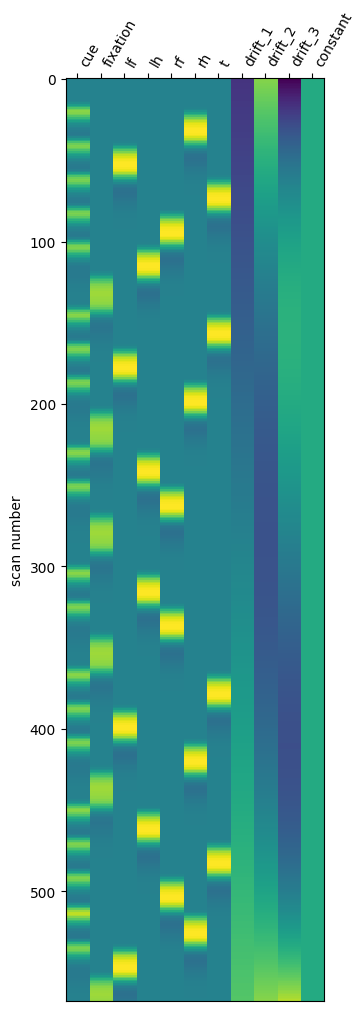

In [11]:
TR = 0.72  # seconds

# fit + design check
glm = FirstLevelModel(
    t_r=TR, hrf_model='spm', smoothing_fwhm=None,
    noise_model='ar1', standardize=False, drift_model='polynomial', # as seen in the lab ## is it very diff from make_drift?
    drift_order=3,
    high_pass=.01, verbose=0
).fit(img_path, events_1)

design = glm.design_matrices_[0]
print(design.shape, list(design.columns))
plot_design_matrix(design)

### 5a. Statistical Maps: Task Related Regressors

Run the GLM at the level you deem reasonable and **report the statistical maps of each of the task-related regressors**. Briefly comment on the statistical maps and, if you can, relate them to the corresponding task. 

/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_11523/760333095.py:2: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  bg  = mean_img(img_path)


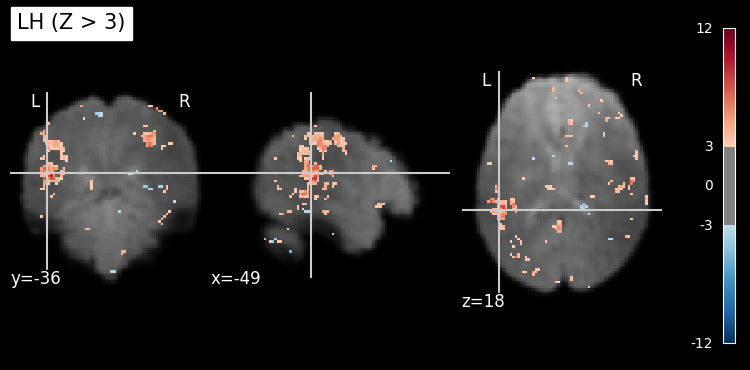

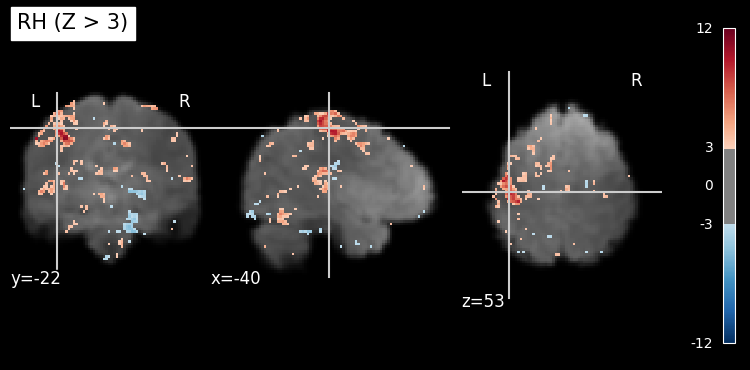

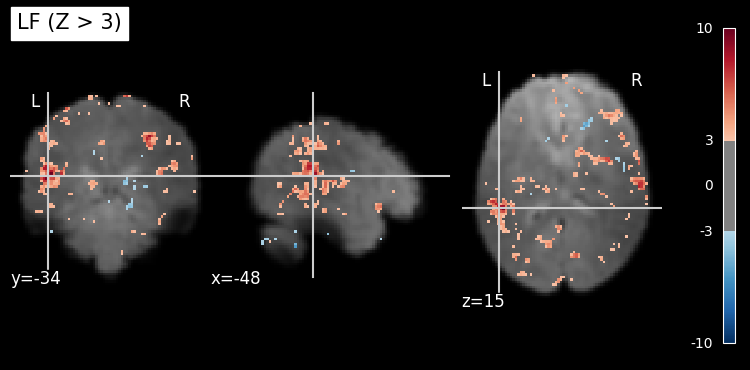

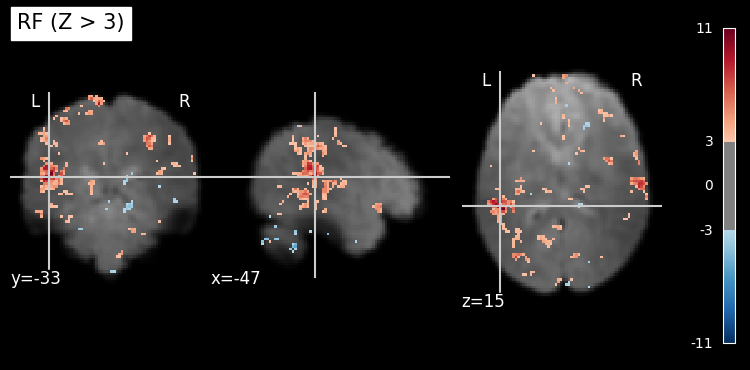

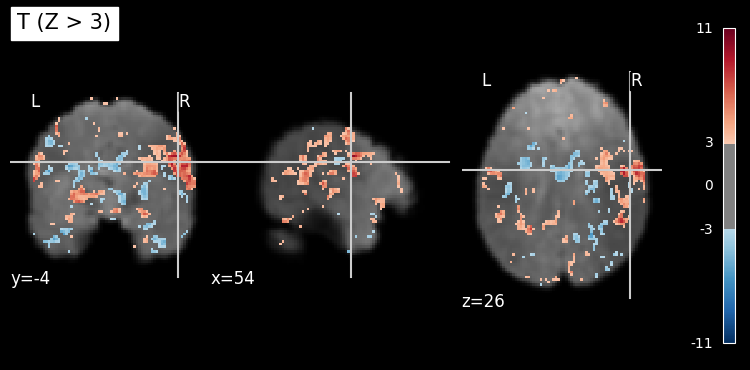

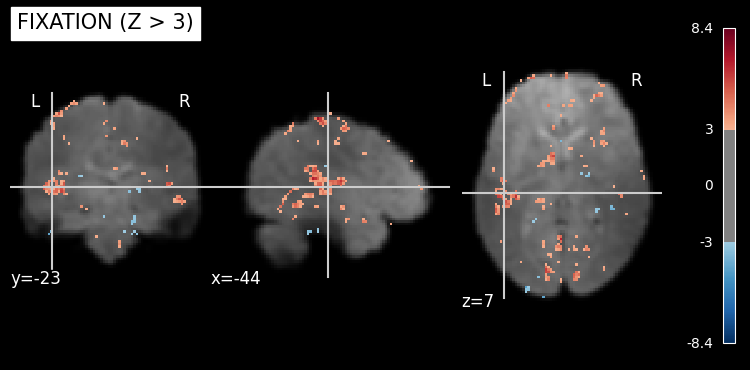

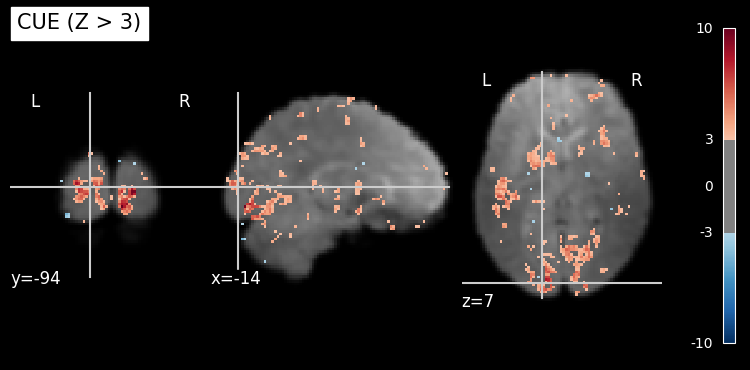

In [12]:
task_conditions = ['lh', 'rh', 'lf', 'rf', 't', 'fixation', 'cue']
bg  = mean_img(img_path)

for cond in task_conditions:
    z_map = glm.compute_contrast(cond, output_type='z_score')

    # Display map (interactive orthogonal view)
    plotting.plot_stat_map(
        z_map,
        bg_img=bg,            
        threshold=3.0,        # only show voxels with Z > 3
        display_mode='ortho', # shows sagittal, coronal, axial slices
        black_bg=True,
        title=f"{cond.upper()} (Z > 3)"
    )

## 6. Contrasts

Using the results of the GLM analysis and a contrast vector of your choice, create the activation maps corresponding to the hand motion against feet motion. Please include in the report the contrast vector used and the contrast map you obtained. 

In [13]:
# 1) Hands(avg) > Feet(avg) + Tongue
z_hands_vs_feet_t = glm.compute_contrast(
    "(lh + rh)/2 - ((lf + rf)/2 + t)",
    output_type="z_score"
)

# 2) Feet(avg) > Hands(avg) + Tongue
z_feet_vs_hands_t = glm.compute_contrast(
    "(lf + rf)/2 - ((lh + rh)/2 + t)",
    output_type="z_score"
)

# 3) Diff between (1) and (2)  ==  2 * (Hands(avg) - Feet(avg))
z_diff_1_2 = glm.compute_contrast(
    "2 * ((lh + rh)/2 - (lf + rf)/2)",
    output_type="z_score"
) 
 
# 4) Hands(avg) > Feet(avg) 
avg_hands_vs_avg_feet = glm.compute_contrast(
    "(lh + rh)/2 - (lf + rf)/2",
    output_type="z_score"
)

### 6a. Statistical maps: FDR and Cluster Correction

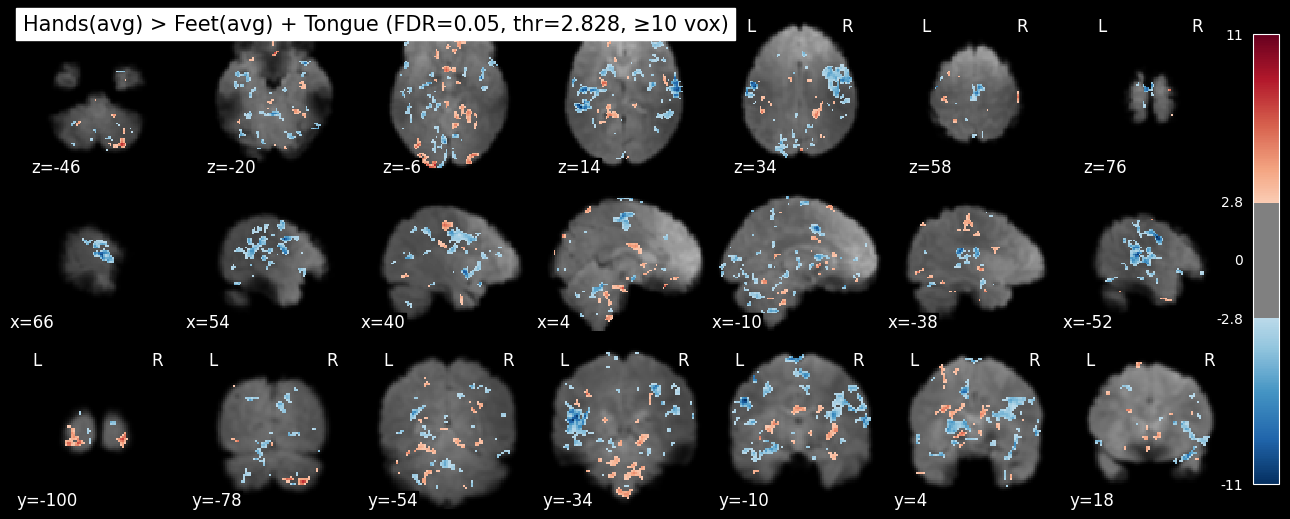

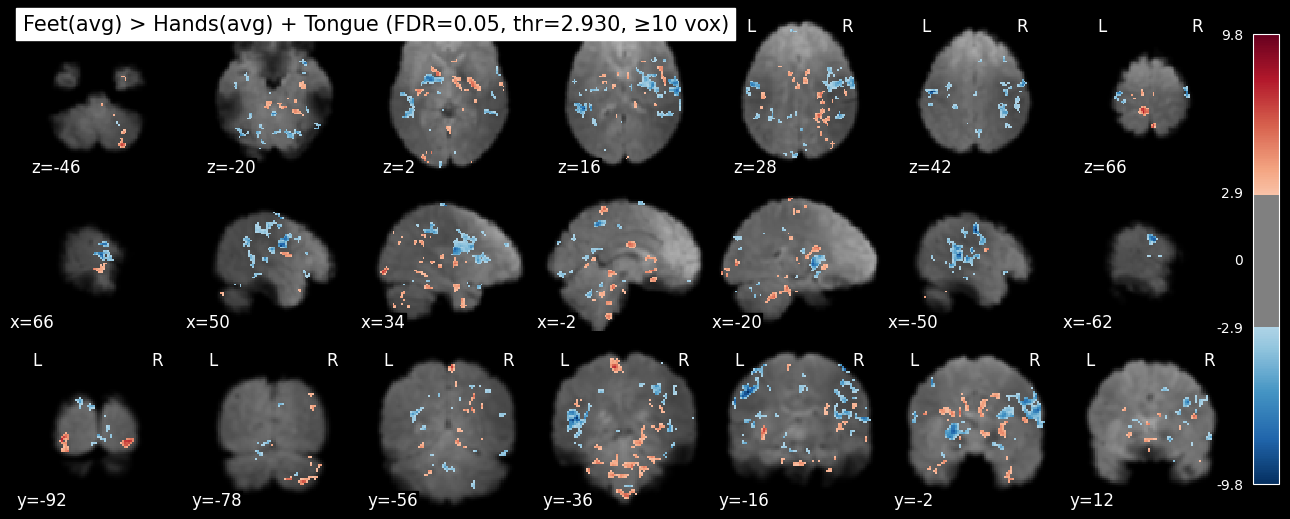

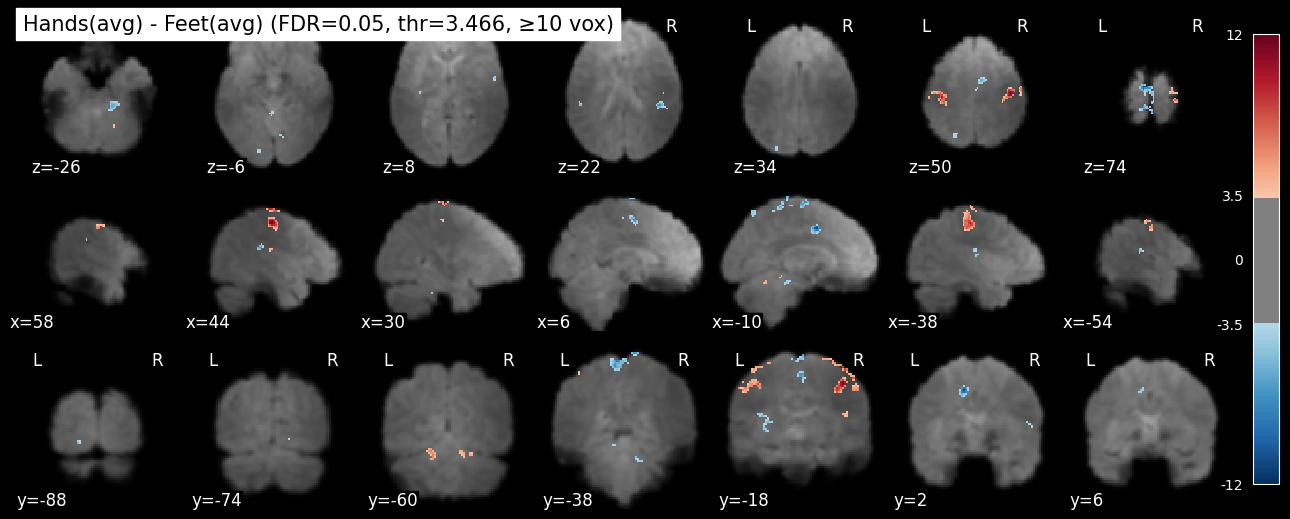

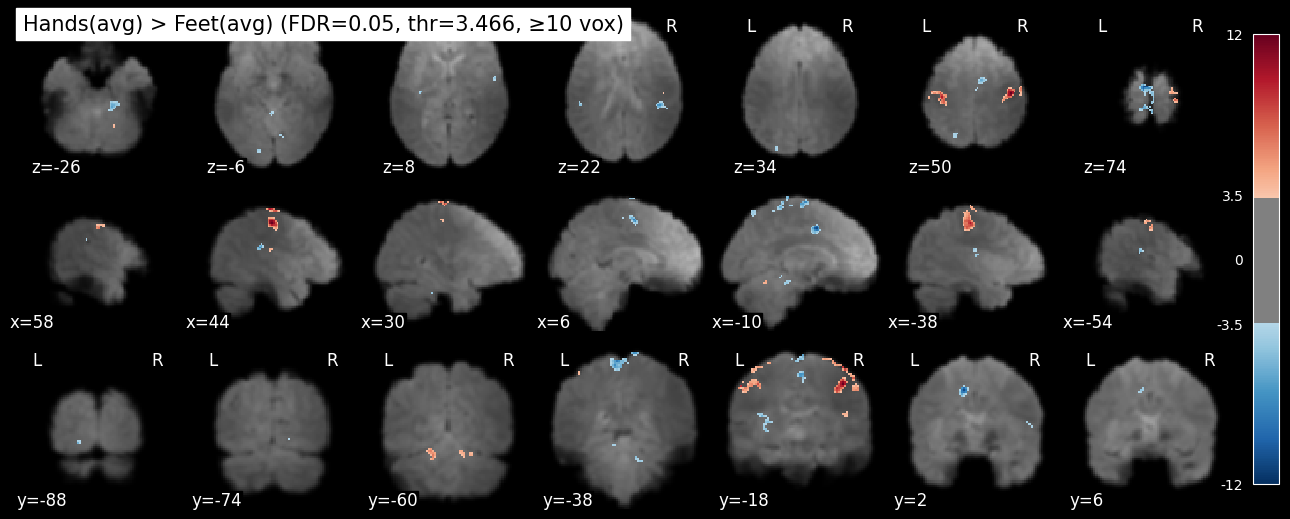

In [14]:

fdr_rate = 0.05
cluster_min = 10  # voxels

def thresh_and_plot(zmap, title):
    clean, thr = threshold_stats_img(
        zmap, alpha=fdr_rate, height_control='fdr',
        cluster_threshold=cluster_min
    )
    plotting.plot_stat_map(
        clean, bg_img=bg, threshold=thr,
        display_mode="mosaic", black_bg=True,
        title=f"{title} (FDR={fdr_rate}, thr={thr:.3f}, ≥{cluster_min} vox)"
    )
    return clean, thr

t1, _ = thresh_and_plot(z_hands_vs_feet_t, "Hands(avg) > Feet(avg) + Tongue")
t2, _ = thresh_and_plot(z_feet_vs_hands_t, "Feet(avg) > Hands(avg) + Tongue")
t3, _ = thresh_and_plot(z_diff_1_2,        "Hands(avg) - Feet(avg)")
t4, _ = thresh_and_plot(avg_hands_vs_avg_feet, "Hands(avg) > Feet(avg)") 

plt.show()


In [15]:
z_hands_vs_feet_t.to_filename("/Users/pamelavandenenden/Desktop/GLM_z_handsAvg_minus_feetAvg_plus_t.nii.gz")
z_feet_vs_hands_t.to_filename("/Users/pamelavandenenden/Desktop/GLM_z_feetAvg_minus_handsAvg_plus_t.nii.gz")
z_diff_1_2.to_filename("/Users/pamelavandenenden/Desktop/GLM_z_diff_1_2.nii.gz")
avg_hands_vs_avg_feet.to_filename("/Users/pamelavandenenden/Desktop/GLM_z_handsAvg_minus_feetAvg.nii.gz")

### 6b. Atlas Superposition 

To better interpret your results, overlay the contrast map with the AAL atlas parcellation (hint: take a look at NiLearn). 

/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_11523/2558547207.py:4: DeprecationWarning: Starting in version 0.13, the default fetched mask will beAAL 3v2 instead.
  aal = datasets.fetch_atlas_aal(version='SPM12')


[fetch_atlas_aal] Dataset found in /Users/pamelavandenenden/nilearn_data/aal_SPM12


/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_11523/2558547207.py:9: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  aal_resampled = image.resample_to_img(aal_img, z_diff_1_2, interpolation='nearest')
/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_11523/2558547207.py:9: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  aal_resampled = image.resample_to_img(aal_img, z_diff_1_2, interpolation='nearest')


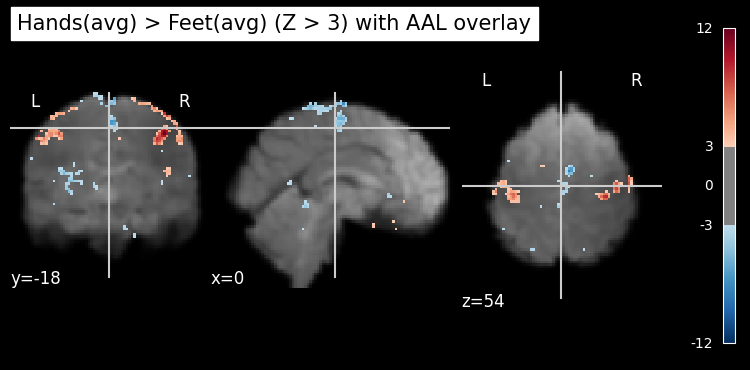

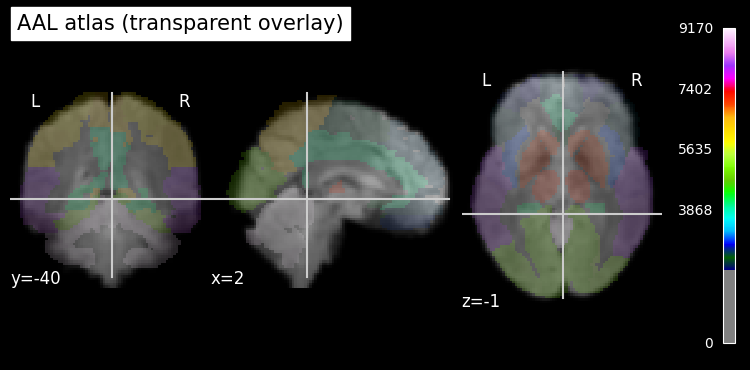

In [16]:
from nilearn import datasets, plotting, image

# Load the AAL atlas
aal = datasets.fetch_atlas_aal(version='SPM12')
aal_img = image.load_img(aal.maps)
aal_labels = aal.labels

# Make sure atlas resolution matches your data
aal_resampled = image.resample_to_img(aal_img, z_diff_1_2, interpolation='nearest')

# Overlay AAL on your contrast map
plotting.plot_stat_map(
    z_diff_1_2,
    bg_img=bg,
    threshold=3.0,
    display_mode='ortho',
    cut_coords=(0, -18, 54),   # around motor cortex
    title="Hands(avg) > Feet(avg) (Z > 3) with AAL overlay",
)
plotting.plot_roi(
    aal_resampled,
    bg_img=bg,
    alpha=0.15,
    title="AAL atlas (transparent overlay)"
)

### 6c. Peak Clusters

Report in which brain regions you find maximal contrast. (Note: the functional data are already in MNI space, so there is no need to do coregistration and normalization!) 

In [17]:
from nilearn.reporting import get_clusters_table

peaks = get_clusters_table(z_diff_1_2, stat_threshold=3.0, cluster_threshold=10)

# Main peaks have a non-null cluster size
main_peaks = peaks[peaks["Cluster Size (mm3)"].notna()].copy()
main_peaks = main_peaks.sort_values("Peak Stat", ascending=False)

print(main_peaks[["Cluster ID","X","Y","Z","Peak Stat","Cluster Size (mm3)"]].head(8))

  Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0          1  44.0 -18.0  50.0  12.114656               1936
4          2  36.0 -28.0  70.0  10.961624               2072
5         2a  46.0 -16.0  64.0  10.192358                   
1         1a  40.0 -20.0  42.0   9.937160                   
8          3 -38.0 -22.0  50.0   9.580950               3216
2         1b  36.0 -26.0  54.0   9.153371                   
6         2b  52.0 -22.0  58.0   9.118870                   
9         3a -56.0 -18.0  48.0   9.074626                   


Answer: 
•	Peak 1: MNI [44, −18, 50], Z=12.13 — right precentral gyrus (primary motor cortex, hand area).
•	Peak 2: MNI [36, −28, 70], Z=10.95 — supplementary motor area / superior medial frontal cortex.
•   Peak 3: MNI [−38, −22, 50], Z=9.60 — left precentral gyrus (M1 hand area).
•	Peak 4: MNI [−14, −60, −20], Z=6.31 — left cerebellum (motor regions).
